# Build a P-value interpreter function with ChatGPT

In [1]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [2]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder
%cd /content/drive/MyDrive/Business Analyst course/A-B Testing and Experimentation/Mastering A-B Testing

In [4]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [5]:
# Load the data
# Amazon landing page A/B testing data
df = pd.read_csv("amazon_landing_page.csv")
df.head()

,user_id,group,landing_page,converted
0,851104,control,old_page,0
1,804228,control,old_page,0
2,661590,treatment,new_page,0
3,853541,treatment,new_page,0
4,864975,control,old_page,1


In [6]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   group         294480 non-null  object
 2   landing_page  294480 non-null  object
 3   converted     294480 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


# EDA

In [11]:
# 1. Descriptive Statistics and Data Quality Check

# Generate descriptive statistics for the dataset
desc_stats = df.describe()
print(desc_stats)

# Check missing values and duplicated rows
print(f"\nMissing values in each column:\n {df.isnull().sum()}")
print(f"\nNumber of duplicate entries: {df.duplicated().sum()}")

             user_id      converted
count  294480.000000  294480.000000
mean   787973.538896       0.119658
std     91210.917091       0.324562
min    630000.000000       0.000000
25%    709031.750000       0.000000
50%    787932.500000       0.000000
75%    866911.250000       0.000000
max    945999.000000       1.000000

Missing values in each column:
 user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Number of duplicate entries: 2


In [12]:
# Checking consistency between 'group' and 'landing_page'
# This verifies if all entries where 'group' is 'control' have 'landing_page' set to 'old_page'
consistency_check = (df['group'] == 'control') == (df['landing_page'] == 'old_page')
print(f"\nConsistency between group and landing_page:  {consistency_check.all()}")


Consistency between group and landing_page:  False


In [13]:
# 2. Group Analysis
# Calculate the average conversion rate for each group
group_conversion = df.groupby('group')['converted'].mean()
print("\nConversion rate by group:\n", group_conversion)


Conversion rate by group:
 group
control      0.120399
treatment    0.118918
Name: converted, dtype: float64


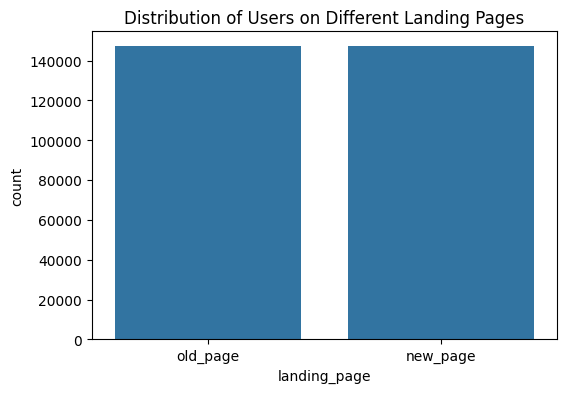

In [14]:
# Plot the count of users for each landing page to visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='landing_page', data=df)
plt.title('Distribution of Users on Different Landing Pages')
plt.show()

# Data Preprocessing

In [15]:
# Removing duplicate entries for user_id
df_unique = df.drop_duplicates(subset='user_id')

In [16]:
# Checking for inconsistencies between group and landing_page

# Identify entries where the 'group' and 'landing_page' values do not match the expected assignment
# 'control' group should have 'old_page' and 'treatment' group should have 'new_page'
inconsistencies = df_unique[((df_unique['group'] == 'control') & (df_unique['landing_page'] != 'old_page')) |
                             ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] != 'new_page'))]

# Counting the number of inconsistencies
num_inconsistencies = inconsistencies.shape[0]
print(f"Number of inconsistencies: {num_inconsistencies}")

Number of inconsistencies: 2044


In [17]:
# Option 1: Remove the inconsistent rows
df_fixed = df_unique.drop(inconsistencies.index)

# Bayesian A/B Testing

In [18]:
# Import libraries
import tensorflow as tf
import tensorflow_probability as tfp

# Alias the distribution module from TensorFlow Probability as 'tfd' for easier access
tfd = tfp.distributions

In [19]:
# Calculate the total number of conversions
conversions_A = df_fixed[(df_fixed['group'] == 'control') & (df_fixed['converted'] == 1)].shape[0]
conversions_B = df_fixed[(df_fixed['group'] == 'treatment') & (df_fixed['converted'] == 1)].shape[0]

# Calculate the total number of observations
total_A = df_fixed[(df_fixed['group'] == 'control')].shape[0]
total_B = df_fixed[(df_fixed['group'] == 'treatment')].shape[0]


In [20]:
# Define the prior distributions for the conversion rates
# Alpha and beta are set to represent a prior belief that conversion rates are typically low,
# with the expectation that values are unlikely to exceed 10.
alpha_prior = 1
beta_prior = 10

In [21]:
# Define the posterior distributions for the conversion rates for each group
# The posterior distribution is calculated using the Beta distribution,
# where the parameters are updated with observed conversions and total counts, incorporating the prior belief.
posterior_A = tfd.Beta(conversions_A + alpha_prior,
                       total_A - conversions_A + beta_prior)
posterior_B = tfd.Beta(conversions_B + alpha_prior,
                       total_B - conversions_B + beta_prior)

In [23]:
# Generate a specified number of samples from the Beta posterior distributions for both groups to estimate the conversion rate distributions.
num_samples = 1000
samples_A = posterior_A.sample(num_samples)
samples_B = posterior_B.sample(num_samples)


In [24]:
# Calculate the probability that B is better than A
# Compare each sample from the posterior of B against the samples from A to determine if B is better
prob_B_better_than_A = tf.reduce_mean(tf.cast(samples_B > samples_A,
                                              dtype = tf.float32))
print(f"Probability that B is better than A is {prob_B_better_than_A.numpy()}")

Probability that B is better than A is 0.0860000029206276


### Proportions test with ChatGPT

**Null Hypothesis**: There is no difference between both groups

**Alternative Hypothesis**: There is a difference in both groups

In [25]:
# Proportions Test
import statsmodels.stats.proportion as proportion

# Perform a two-sample z-test for proportions
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative="two-sided")

# Interpret the p-value from the test to determine statistical significance
interpret_p_value(p_value, threshold=0.05)

p-value (0.19534709281210638) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


In [26]:
# Proportions Test
import statsmodels.stats.proportion as proportion

# Perform a one-sided z-test for proportions
# Testing if the proportion in group B is significantly larger than in group A
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative="larger")

# Interpret the p-value from the test to determine if B's conversion rate is significantly larger than A's
interpret_p_value(p_value, threshold=0.05)


p-value (0.09767354640605319) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


# Sequential Testing and Early Stopping

In [27]:
# Simulate Experiments
n_experiments = 1000  # Number of experiments to simulate
n_weeks = 5  # Duration of each experiment in weeks
n_per_week = 500  # Number of participants per week in each experiment

# Conversion rates for the control and treatment groups
cr_control = 0.12  # Conversion rate for the control group
cr_treatment = 0.11  # Conversion rate for the treatment group

In [28]:
# Running the simulations
early_stopping_results = []  # List to store results of early stopping

# Simulate for each experiment
for _ in range(n_experiments):
  # Simulate conversion data for the control group and treatment group
  control_group = np.random.binomial(1, cr_control, n_per_week * n_weeks)
  treatment_group = np.random.binomial(1, cr_treatment, n_per_week * n_weeks)

  # Sequentially analyze each week
  for week in range(1, n_weeks + 1):
    # Slice the data up to the current week
    control_data = control_group[:week * n_per_week]
    treatment_data = treatment_group[:week * n_per_week]

    # Prepare data for proportions test and perform the test
    z_value, p_value = proportion.proportions_ztest(
        [control_data.sum(), treatment_data.sum()],
        [len(control_data), len(treatment_data)])

    # Check if the p-value is below the significance level (0.05)
    if p_value < 0.05:
      early_stopping_results.append((week, p_value))  # Record week and p-value if significant
      break  # Stop the simulation for this experiment if result is significant
  else:
    # If no significant result was found, record the results at the end of the experiment
    early_stopping_results.append((n_weeks, p_value))


In [29]:
# Check the results
early_stopping_results

[(5, 0.589911597379234),
 (5, 0.13263238034063493),
 (5, 0.590492823290573),
 (2, 0.0018720220253828372),
 (5, 0.7210298218894663),
 (1, 0.018645975079871882),
 (5, 0.1361048653258733),
 (5, 0.4411703263769804),
 (2, 0.010694161765351448),
 (5, 0.03590288932573656),
 (5, 0.9639203755524058),
 (5, 0.930540797744794),
 (5, 0.04153981864070479),
 (5, 0.44762137074450914),
 (5, 0.08054477209597526),
 (4, 0.027277190960552596),
 (5, 0.7901009719060869),
 (5, 0.0880287712390313),
 (5, 0.08040264132108584),
 (1, 0.03827898195165756),
 (5, 0.5922183021651667),
 (5, 0.9291920562400767),
 (5, 0.2670321116932822),
 (5, 0.05625332707681538),
 (1, 0.04234332221693482),
 (5, 0.22921631894666017),
 (5, 0.6916780613054787),
 (5, 0.8610082807520816),
 (5, 0.3161478616869857),
 (5, 0.825107016060501),
 (5, 0.3749362481540166),
 (5, 0.11823786630868324),
 (5, 0.4811183886993423),
 (5, 0.29425943252299513),
 (5, 0.1881689518646874),
 (5, 0.6323872470547119),
 (5, 0.37994405269371145),
 (5, 0.4590796376233

In [30]:
# Analyze the results

# Unpack the weeks and p-values from the early stopping results
stopped_weeks, stopped_p_values = zip(*early_stopping_results)

# Calculate the average week at which early stopping occurred
average_stopping_week = np.mean(stopped_weeks)

# Print the average stopping week across all simulations
print(f"The Average Stopping week is {average_stopping_week}")


The Average Stopping week is 4.321


# A/B/C Tests


In [31]:
# Load the data
df_netflix = pd.read_csv("netflix_wednesday_thumbnail.csv")
df_netflix.head(10)

,Participant ID,Thumbnail Variant,Watched Show,Minutes Watched
0,1,Thumbnail A,True,25
1,2,Thumbnail B,False,0
2,3,Thumbnail A,False,0
3,4,Thumbnail B,False,0
4,5,Thumbnail B,True,46
5,6,Thumbnail C,True,1
6,7,Thumbnail A,False,0
7,8,Thumbnail C,False,0
8,9,Thumbnail A,True,15
9,10,Thumbnail A,False,0


In [32]:
# 1. Descriptive Statistics
df_netflix.describe()

,Participant ID,Minutes Watched
count,20000.000000,20000.000000
mean,10000.500000,15.179150
std,5773.647028,19.285418
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,1.000000
75%,15000.250000,31.000000
max,20000.000000,59.000000


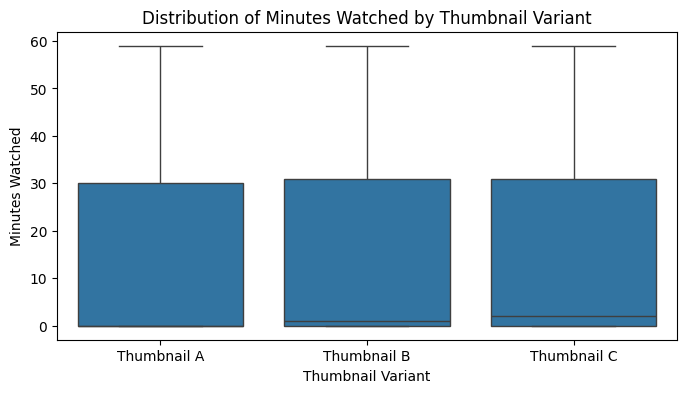

In [33]:
# 2. Distribution Analysis

# Create a boxplot to visualize the distribution of 'Minutes Watched' by 'Thumbnail Variant'
plt.figure(figsize=(8, 4))
sns.boxplot(x='Thumbnail Variant', y='Minutes Watched', data=df_netflix)
plt.title('Distribution of Minutes Watched by Thumbnail Variant')
plt.show()

In [34]:
# 3. Calculate the proportion of users who watched the show, grouped by 'Thumbnail Variant'
watched_show_proportion = df_netflix.groupby('Thumbnail Variant')['Watched Show'].mean()
print(watched_show_proportion)

Thumbnail Variant
Thumbnail A    0.494050
Thumbnail B    0.503876
Thumbnail C    0.508342
Name: Watched Show, dtype: float64


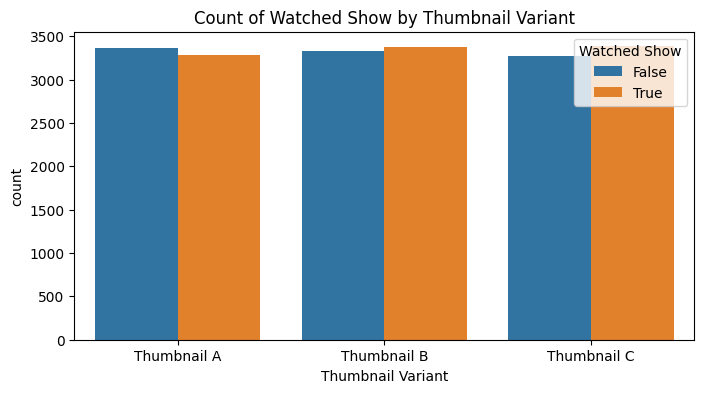

In [35]:
# 5. Visualization of Watched Show and Thumbnail Variant

# Create a count plot to show the number of users who watched or did not watch the show, grouped by 'Thumbnail Variant'
plt.figure(figsize=(8, 4))
sns.countplot(x='Thumbnail Variant', hue='Watched Show', data=df_netflix)
plt.title('Count of Watched Show by Thumbnail Variant')
plt.show()

### Chi Square Test with ChatGPT

Null Hypothesis: There is no relationship between the thumbnails and people watching the show

Alternative Hypothesis: There is a relationship between the thumbnails and people watching the show

In [36]:
# Creating a contingency table to summarize the counts of 'Watched Show' by 'Thumbnail Variant'
contingency = pd.crosstab(df_netflix['Thumbnail Variant'], df_netflix['Watched Show'])

# Performing the Chi-Square test of independence
# This tests whether there is a significant association between 'Thumbnail Variant' and 'Watched Show'
chi2, p, dof, expected = stats.chi2_contingency(contingency)

# Interpret the p-value to determine if there is a statistically significant association
interpret_p_value(p, threshold=0.05)

p-value (0.24143033666177097) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


If the outcome of the Chi-Square test is statistically significant, you would then apply the Bonferroni correction to account for multiple comparisons. This method involves adjusting the significance threshold by dividing the desired alpha level (e.g., 0.05) by the number of comparisons performed.

### Bonferroni Method

In [37]:
from itertools import combinations

In [38]:
# Create a list of all possible pairs of 'Thumbnail Variant' for pairwise comparisons
combinations = list(combinations(df_netflix['Thumbnail Variant'].unique(), 2))

In [39]:
# Bonferroni method adjustment
# Adjust the significance threshold for multiple comparisons
adjusted_alpha = 0.05 / len(combinations)
significant_pairs = []

# Loop through each combination to perform pairwise chi-square tests
for combo in combinations:
  # Creating a contingency table for the current pair of thumbnail variants
  contingency = pd.crosstab(
      df_netflix[df_netflix['Thumbnail Variant'].isin(combo)]['Thumbnail Variant'],
      df_netflix['Watched Show'])

  # Performing the chi-square test for the current contingency table
  chi2, p, dof, expected = stats.chi2_contingency(contingency)

  # Check if the p-value is less than the adjusted alpha
  if p < adjusted_alpha:
    significant_pairs.append((combo, p))

# Print significant pairs after Bonferroni adjustment
print(f"Significant pairs after the Bonferroni adjustment: {significant_pairs}")

Significant pairs after the Bonferroni adjustment: []


### ANOVA Test

Null Hypothesis: There is no difference between the variants

Alternative: There are differences between the groups

In [40]:
# Create groups
group_a = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail A']['Minutes Watched']
group_b = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail B']['Minutes Watched']
group_c = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail C']['Minutes Watched']

In [41]:
# Perform the ANOVA test
F, p_value = stats.f_oneway(group_a,group_b, group_c)
interpret_p_value(p_value, threshold=0.05)

p-value (0.5770534842828645) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


### Hukey's HSD

In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [43]:
# Perform the ANOVA test
# This tests whether there are statistically significant differences in means across the groups
F, p_value = stats.f_oneway(group_a, group_b, group_c)

# Interpret the p-value to determine if the differences among groups are statistically significant
interpret_p_value(p_value, threshold=0.05)

p-value (0.5770534842828645) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.
